# Concept Gloss Encoding with encoder and mapping to concept

Here, encodes concept glosses using Qwen model to extract CLS token embeddings.

Each gloss is tokenized and passed through Qwen, producing a fixed-size embedding vector.

Then the embedded glosses is mapped into the RotE concept embeddings, and analyzed

### Setup

In [59]:
# !pip install sentence-transformers>=2.7.0

In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import List, Tuple, Optional, Union
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

TSV_FILE = 'rawdata/concepts_gloss.tsv'
df = pd.read_csv(TSV_FILE, sep='\t')
required_columns = ['id', 'concept_label', 'gloss']

glosses = df['gloss'].tolist()
concept_ids = df['id'].tolist()
concept_labels = df['concept_label'].tolist()

concept_ids_array = np.array(concept_ids)
concept_labels_array = np.array(concept_labels)

word_counts = [len(gloss.split()) for gloss in glosses]

print({df.shape})
print(df.head(3))

device_available = torch.cuda.is_available()
device = torch.device('cuda' if device_available else 'mps' if torch.backends.mps.is_available() else 'cpu')

{(37123, 3)}
      id concept_label                             gloss
0  54637  fungus_genus            includes lichen genera
1  35389    disrespect  an expression of lack of respect
2  24791   wagon_wheel                a wheel of a wagon


### Initialize pretrained tokenizer and model (sentence-transformers)

In [ ]:
# MODEL_NAME = 'jhu-clsp/mmBERT-base'
MODEL_NAME = 'Qwen/Qwen3-Embedding-8B'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {DEVICE}")

model = SentenceTransformer(MODEL_NAME)
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# print(f" vocab size: {tokenizer.vocab_size}")
# print(f" max seqeunce len: {tokenizer.model_max_length}")

model.to(DEVICE)
HIDDEN_SIZE = model.get_sentence_embedding_dimension()
print(f"model: {MODEL_NAME}")
print(f"emb dimension: {HIDDEN_SIZE}")

device: cuda


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


model: Qwen/Qwen3-Embedding-8B
emb dimension: 4096


### Encoding gloss dataset in batch with sentence transformer

In [ ]:
from typing import Tuple, List

class GlossDataset(Dataset):
    def __init__(self, glosses: List[str]):
        self.glosses = glosses
    def __len__(self) -> int:
        return len(self.glosses)
    def __getitem__(self, idx: int) -> str:
        return self.glosses[idx]


def encode_dataset(
    glosses: List[str],
    model: SentenceTransformer,
    device: str = None,
    batch_size: int = 64,
    show_progress: bool = True
) -> Tuple[np.ndarray, int]:
    if device is None:
        device = globals().get('DEVICE', 'cuda' if torch.cuda.is_available() else 'cpu')
    N = len(glosses)
    embeddings_list = []
    for i in tqdm(range(0, N, batch_size), desc='Encoding batches'):
        batch = glosses[i:i+batch_size]
        emb = model.encode(
            batch,
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            device=device
        )
        embeddings_list.append(emb)
    embeddings = np.vstack(embeddings_list)
    return embeddings, N

embs, n = encode_dataset(glosses, model, device=None, batch_size=32, show_progress=False)
print('Encoded shape:', embs.shape)

all_embeddings = embs

Encoding batches: 100%|██████████| 1161/1161 [34:13<00:00,  1.77s/it]


Encoded shape: (37123, 4096)


### Normalizing and processing embeddings

We're keeping both raw and normalized embedding for the further testing modes.

Moreover, saving the embeddings for the convenience of later direct use.

In [ ]:
def l2_normalize(embeddings: np.ndarray) -> np.ndarray:
    """
    L2-normalize embeddings to unit vectors.
    """
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    norms = np.maximum(norms, 1e-12)
    normalized = embeddings / norms
    
    return normalized

embeddings_raw = all_embeddings.copy()
print(f"{embeddings_raw.shape}")
print(f"emb norm: {np.linalg.norm(embeddings_raw[0]):.4f}")
embeddings_normalized = l2_normalize(all_embeddings)
print(f"{embeddings_normalized.shape}")
print(f"emb norm: {np.linalg.norm(embeddings_normalized[0]):.4f}")

embeddings_to_save = embeddings_normalized

output_file = 'qwen_concept_embeddings.npz'
np.savez_compressed(
    output_file,
    concept_ids=concept_ids_array,
    concept_labels=concept_labels_array,
    embeddings=embeddings_to_save
)

output_file_raw = 'qwen_concept_embeddings_raw.npz'
np.savez_compressed(
    output_file_raw,
    concept_ids=concept_ids_array,
    concept_labels=concept_labels_array,
    embeddings=embeddings_raw
)

print(f"\nConcepts encoded: {len(concept_ids_array)}")
print(f"Embedding dimension: {embeddings_to_save.shape[1]}")

(37123, 4096)
emb norm: 1.0000
(37123, 4096)
emb norm: 1.0000

Concepts encoded: 37123
Embedding dimension: 4096


### Load embeddings

In [ ]:
output_file = 'qwen_concept_embeddings_raw.npz'
loaded_data = np.load(output_file)

loaded_ids = loaded_data['concept_ids']
loaded_labels = loaded_data['concept_labels']
loaded_embeddings = loaded_data['embeddings']

l2_norms = np.linalg.norm(loaded_embeddings, axis=1)

print("Example")
for i in range(1):
    print(f"  concept {loaded_ids[i]}, '{loaded_labels[i]}', norm: {l2_norms[i]:.6f}")
    print(f"  embedding ([:5]]): {loaded_embeddings[i, :5]}")

Example
  concept 54637, 'fungus_genus', norm: 1.000000
  embedding ([:5]]): [ 0.01540759  0.00548622  0.00916545 -0.02874994  0.00542647]


### Load RotE embeddings and align dimensions (500)

In [ ]:
import os
import torch
import pickle

ROTE_PT = 'RotE_model_20251201_144211_best.pt'

rote_ckpt = torch.load(ROTE_PT, map_location='cpu')

def get_embeddings(obj):
    """Return list of (key, tensor) where tensor.ndim==2 and tensor.shape[1]==500."""
    rote_embeddings = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[1] == 500:
                rote_embeddings.append((k, v))
    return rote_embeddings

rote_emb = None
rote_meta = {}

if isinstance(rote_ckpt, dict):
    if 'state_dict' in rote_ckpt:
        state = rote_ckpt['state_dict']
    else:
        state = rote_ckpt

    rote_embeddings = get_embeddings(state)

    if len(rote_embeddings) > 0:
        preferred = None
        for k, v in rote_embeddings:
            kn = k.lower()
            if 'entity' in kn or 'concept' in kn or 'emb' in kn:
                preferred = (k, v)
                break
        if preferred is None:
            preferred = rote_embeddings[0]
        emb_key, emb_tensor = preferred
        rote_emb = emb_tensor.detach().cpu().float()
        rote_meta['source_key'] = emb_key
    else:
        for k, v in state.items():
            if isinstance(v, (list, tuple)) and len(v) > 0 and all(isinstance(x, str) for x in v):
                print(f"list mapping")

    if rote_emb is None:
        rote_embeddings_top = get_embeddings(rote_ckpt)
        for k, v in rote_embeddings_top:
            print(f"rote_emb shape: {tuple(v.shape)}")
        if len(rote_embeddings_top) > 0:
            rote_emb = rote_embeddings_top[0][1].detach().cpu().float()

else:
    if isinstance(rote_ckpt, torch.Tensor) and rote_ckpt.ndim == 2 and rote_ckpt.shape[1] == 500:
        rote_emb = rote_ckpt.detach().cpu().float()
    elif hasattr(rote_ckpt, 'state_dict'):
        sd = rote_ckpt.state_dict()
        rote_embeddings = get_embeddings(sd)
    
        for k, v in rote_embeddings:
            print(f" {tuple(v.shape)}")
        if len(rote_embeddings) > 0:
            rote_emb = rote_embeddings[0][1].detach().cpu().float()

print(f"RotE embedding {tuple(rote_emb.shape)}, dtype={rote_emb.dtype}")

rote_emb_np = rote_emb.numpy()

N_qwen = loaded_embeddings.shape[0]
N_rote = rote_emb_np.shape[0]


mapping_paths = [
    'rawdata/entity_to_id.pickle',
    'UKC_CUT_1_hyp_t/entity_to_id.pickle',
    os.path.join('UKC_CUT_1_hyp_t', 'entity_to_id.pickle'),
    os.path.join('cpt_llm', 'UKC_CUT_1_hyp_t', 'entity_to_id.pickle')
]

entity_to_id_mapping = None
for p in mapping_paths:
    if os.path.exists(p):
        with open(p, 'rb') as fh:
            entity_to_id_mapping = pickle.load(fh)
        rote_meta['entity_to_id_path'] = p

if isinstance(entity_to_id_mapping, list):
    entity2idx = {str(ent): idx for ent, idx in entity_to_id_mapping}
elif isinstance(entity_to_id_mapping, dict):
    entity2idx = {str(k): v for k, v in entity_to_id_mapping.items()}

concepts_csv_paths = [
    'rawdata/concepts.csv',
    'cpt_llm/rawdata/concepts.csv'
]
concepts_df = None
for p in concepts_csv_paths:
    if os.path.exists(p):
        concepts_df = pd.read_csv(p)
        
paired_indices = []
matched_count = 0

for i, (cid, clabel) in enumerate(zip(concept_ids_array, concept_labels_array)):
    cid_str = str(cid)
    
    rote_idx = entity2idx.get(cid_str, None)
    if rote_idx is not None:
        paired_indices.append(rote_idx)
        matched_count += 1
        continue
    
    if concepts_df is not None:
        matching_rows = concepts_df[concepts_df['concept_id'].astype(str) == cid_str]
        if len(matching_rows) > 0:
            csv_label = str(matching_rows.iloc[0]['label']).strip()
            rote_idx = entity2idx.get(csv_label, None)
            if rote_idx is not None:
                paired_indices.append(rote_idx)
                matched_count += 1
                continue
    
    paired_indices.append(-1)

paired_indices = np.array(paired_indices, dtype=int)

if 'paired_indices' not in locals() or paired_indices is None:
    paired_indices = np.arange(N_qwen)

mask_valid = paired_indices >= 0
if not np.all(mask_valid):
    print(f"Filtering out {np.sum(~mask_valid)} unmatched concepts from training set.")

paired_idx_clean = paired_indices[mask_valid]
Qwen_X = loaded_embeddings[mask_valid]
rote_Y = rote_emb_np[paired_idx_clean]

print(f"qwen: {Qwen_X.shape}, rotY: {rote_Y.shape}")

Qwen_X = Qwen_X.astype('float32')
rote_Y = rote_Y.astype('float32')

RotE embedding (37123, 500), dtype=torch.float32
qwen: (37123, 4096), rotY: (37123, 500)


### Train a mapper from Qwen gloss -> RotE concept (768 -> 500)


Training device: cuda


Epoch: 100%|██████████| 50/50 [01:28<00:00,  1.78s/it]



Final metrics on TEST set:
  - Mean cosine: 0.633676
  - MSE: 1.745968e-03


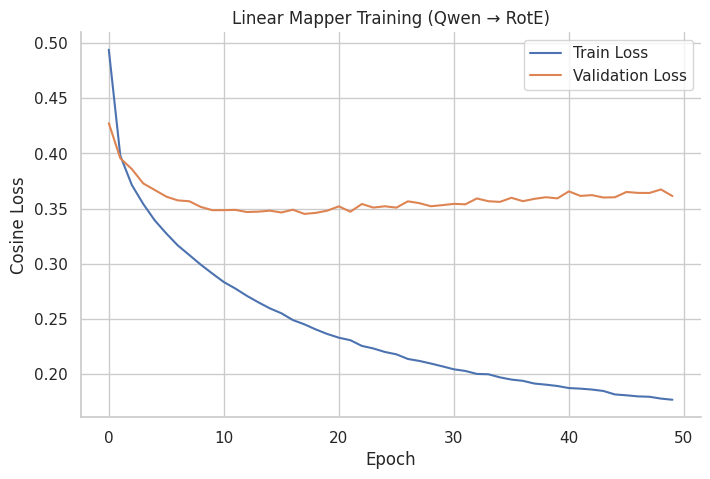

Model saved to linear_mapper_qwen_to_rote.pt


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training device: {device}")

IN_DIM = Qwen_X.shape[1]   # qwen embedding dim
OUT_DIM = rote_Y.shape[1]  # rote embedding dim
BATCH_SIZE = 64
EPOCHS = 50
LR = 1e-4
# LR = 1e-3
WEIGHT_DECAY = 1e-5
SHOW_EXAMPLES = 10
TOP_K = 10

X_norm = Qwen_X / np.maximum(np.linalg.norm(Qwen_X, axis=1, keepdims=True), 1e-12)
Y_norm = rote_Y / np.maximum(np.linalg.norm(rote_Y, axis=1, keepdims=True), 1e-12)

X_t = torch.from_numpy(X_norm).float()
Y_t = torch.from_numpy(Y_norm).float()


dataset = TensorDataset(X_t, Y_t)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class LinearMapper(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=1024, use_bias=True):
        super().__init__()
        # self.linear = nn.Linear(in_dim, out_dim, bias=use_bias)
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)
        # return self.linear(x)

# optional to try
class MapperWithDecoder(nn.Module):
    def __init__(self, in_dim, mid_dim, hidden_dim=1024):
        super().__init__()
        # self.encoder = nn.Linear(in_dim, mid_dim)
        # self.decoder = nn.Linear(mid_dim, in_dim)

        # Encoder: input -> hidden -> mid_dim
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, mid_dim)
        )
        # Decoder: mid_dim -> hidden -> input
        self.decoder = nn.Sequential(
            nn.Linear(mid_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )
        
        self.map_out = nn.Identity()  # encoder output is mid-dim

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return z, recon
    
model = LinearMapper(IN_DIM, OUT_DIM).to(device)

def cosine_loss(x, y):
    x_norm = x / x.norm(dim=1, keepdim=True)
    y_norm = y / y.norm(dim=1, keepdim=True)
    return 1 - (x_norm * y_norm).sum(dim=1).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

loss_history = []
val_loss_history = []

for epoch in tqdm(range(1, EPOCHS + 1), desc="Epoch"):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = cosine_loss(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_dataset)
    loss_history.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = cosine_loss(out, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dataset)
    val_loss_history.append(val_loss)


model.eval()
with torch.no_grad():
    test_X = torch.cat([xb for xb, _ in test_loader]).to(device)
    test_Y = torch.cat([yb for _, yb in test_loader]).to(device)
    mapped_all = model(test_X).cpu().numpy()
    mapped_norm = mapped_all / (np.linalg.norm(mapped_all, axis=1, keepdims=True) + 1e-12)
    rote_norm_test = test_Y.cpu().numpy() / (np.linalg.norm(test_Y.cpu().numpy(), axis=1, keepdims=True) + 1e-12)
    cos_test = (mapped_norm * rote_norm_test).sum(axis=1).mean()
    mse_test = ((mapped_all - test_Y.cpu().numpy()) ** 2).mean()

print(f"\nFinal metrics on TEST set:")
print(f"  - Mean cosine: {cos_test:.6f}")
print(f"  - MSE: {mse_test:.6e}")

plt.figure(figsize=(8,5))
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cosine Loss')
plt.title('Linear Mapper Training (Qwen → RotE)')
plt.grid(True)
plt.legend()
plt.show()


checkpoint_path = "linear_mapper_qwen_to_rote.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "in_dim": IN_DIM,
    "out_dim": OUT_DIM,
    "epoch": EPOCHS,
    "train_loss": loss_history,
    "val_loss": val_loss_history,
}, checkpoint_path)

print(f"Model saved to {checkpoint_path}")

### Evaluate the mapping

Get and analyse the top-k neighbors from the mappings

In [ ]:
model.eval()
with torch.no_grad():
    mapped_all = model(X_t.to(device)).cpu().numpy()
    mapped_norm = mapped_all / np.linalg.norm(mapped_all, axis=1, keepdims=True)
    Y_norm_np = Y_norm 

    cos_sim_matrix = mapped_norm @ Y_norm_np.T 

    top_k_indices = np.argsort(-cos_sim_matrix, axis=1)[:, :TOP_K]
    top_k_scores  = np.take_along_axis(cos_sim_matrix, top_k_indices, axis=1)

random_indices = np.random.choice(len(mapped_all), size=SHOW_EXAMPLES, replace=False)
print("\ntop-k neighbors ranking\n")
for i in random_indices:
    print(f"Concept #{i}: {concept_labels_array[i]} (ID: {concept_ids_array[i]})")
    for k in range(TOP_K):
        idx = top_k_indices[i, k]
        score = top_k_scores[i, k]
        print(f"  Top {k+1}: RotE #{idx} | label={concept_labels_array[idx]} | cosine={score:.4f}")
    print()



top-k neighbors ranking

Concept #2349: share (ID: 62773)
  Top 1: RotE #2349 | label=share | cosine=0.7729
  Top 2: RotE #25716 | label=liquid_assets | cosine=0.7673
  Top 3: RotE #32862 | label=intangible | cosine=0.7654
  Top 4: RotE #35288 | label=reserve_assets | cosine=0.7619
  Top 5: RotE #15493 | label=credit | cosine=0.7369
  Top 6: RotE #7636 | label=material_resource | cosine=0.7272
  Top 7: RotE #17970 | label=investment | cosine=0.7267
  Top 8: RotE #14174 | label=resource | cosine=0.7229
  Top 9: RotE #6906 | label=security | cosine=0.7193
  Top 10: RotE #14794 | label=sum | cosine=0.7176

Concept #28754: ghanaian (ID: 92015)
  Top 1: RotE #36443 | label=georgian | cosine=0.9989
  Top 2: RotE #28314 | label=turkmen | cosine=0.9989
  Top 3: RotE #29222 | label=rwandan | cosine=0.9989
  Top 4: RotE #19905 | label=palauan | cosine=0.9989
  Top 5: RotE #29813 | label=gibraltarian | cosine=0.9989
  Top 6: RotE #30401 | label=faroese | cosine=0.9989
  Top 7: RotE #26959 | labe

### GEODESIC analysis

Use nearest neighbors and sampling (smaller sample for a fast test)

Quick geodesic analysis start...
Relations loaded: (108637, 7)
Using src_con_id trg_con_id
Graph: 88707 nodes, 108001 edges
Index built


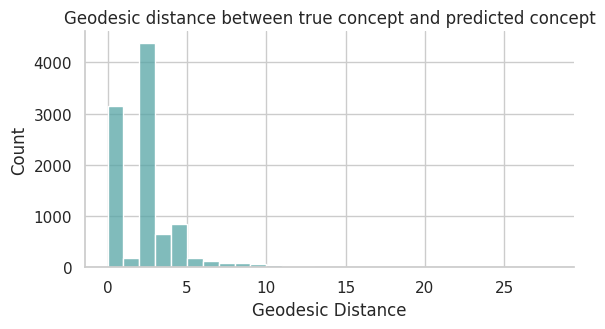

In [ ]:
import os, numpy as np, pandas as pd, networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt, seaborn as sns

from pathlib import Path

print('Quick geodesic analysis start...')

p = os.path.join('rawdata', 'concept_relations.csv')
if not os.path.exists(p):
    p = os.path.join('cpt_llm', 'rawdata', 'concept_relations.csv')
if not os.path.exists(p):
    raise RuntimeError('concept_relations.csv not found')
rels = pd.read_csv(p)
print('Relations loaded:', rels.shape)

# Guess columns for src/trg
cols = [c.lower() for c in rels.columns]
if 'src_con_id' in cols and 'trg_con_id' in cols:
    srcc = rels.columns[cols.index('src_con_id')]
    tgtc = rels.columns[cols.index('trg_con_id')]
else:
    srcc, tgtc = rels.columns[0], rels.columns[1]
print('Using', srcc, tgtc)

G = nx.Graph()
G.add_edges_from(zip(rels[srcc].astype(str), rels[tgtc].astype(str)))
print('Graph:', G.number_of_nodes(), 'nodes,', G.number_of_edges(), 'edges')


if 'mapped_norm' not in globals():
    if 'model' not in globals():
        raise RuntimeError('Mapper not available')
    with __import__('torch').no_grad():
        mapped_np = model(__import__('torch').from_numpy(Qwen_X.astype('float32'))).numpy()
    mapped_norm = normalize(mapped_np, axis=1)
rote_norm_local = normalize(rote_emb_np, axis=1)

idx2entity_local = {int(v): str(k) for k,v in entity2idx.items()}

K=1
nn = NearestNeighbors(n_neighbors=K, metric='cosine', n_jobs=4)
nn.fit(rote_norm_local)
print('Index built')

# sample small set
M = mapped_norm.shape[0]

sample = min(10000, M)
np.random.seed(1)
idxs = np.random.choice(M, sample, replace=False)

found = []
for ii in idxs:
    dists, nbs = nn.kneighbors(mapped_norm[ii:ii+1], return_distance=True)
    sims = 1.0 - dists.flatten()
    for nb_idx in nbs.flatten():
        ent = idx2entity_local.get(int(nb_idx), None)
        if ent is None:
            continue
        src = str(concept_ids_array[ii])
        try:
            if src in G and ent in G:
                L = nx.shortest_path_length(G, source=src, target=ent)
                found.append(L)
        except nx.NetworkXNoPath:
            pass


out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

found_csv = out_dir / "geodesic_distances.csv"
pd.DataFrame({"geodesic_distance": found}).to_csv(found_csv, index=False)

if len(found)>0:
    plt.figure(figsize=(6,3))
    sns.histplot(found, bins=range(0, max(found)+2), color="#55a4a5",)
    plt.tight_layout()
    plt.title('Geodesic distance between true concept and predicted concept')
    plt.xlabel('Geodesic Distance')
    out='geodesic_distance.png'
    plt.savefig(out)
    plt.show()
else:
    print('No distances found in sample')

In [ ]:
# founda = pd.read_csv("outputs/geodesic_distances.csv")['geodesic_distance'].tolist()
# if len(founda)>0:
#     plt.figure(figsize=(6,3))
#     sns.histplot(founda, bins=range(0, max(founda)+2), color="#55a4a5",)
#     plt.tight_layout()
#     plt.title('Geodesic distance between true concept and mapped concept', pad=15)
#     plt.xlabel('Geodesic Distance')
#     out='geodesic_distance.png'
#     plt.savefig(out)
#     plt.show()

### For checking the baseline of the distance distribution for comparing the result.

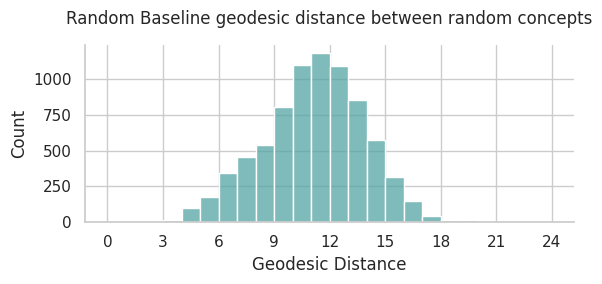

In [ ]:
import random
import matplotlib.ticker as mticker

found_random = []
all_nodes = list(G.nodes())
M = mapped_norm.shape[0]
sample = min(10000, M)
np.random.seed(1)
idxs = np.random.choice(M, sample, replace=False)

np.random.seed(42)
random.seed(42)

for ii in idxs:
    src = str(concept_ids_array[ii])
    tgt = random.choice(all_nodes)
    if src in G and tgt in G:
        try:
            L = nx.shortest_path_length(G, source=src, target=tgt)
            found_random.append(L)
        except nx.NetworkXNoPath:
            pass

out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

found_csv = out_dir / "geodesic_distances_random.csv"
pd.DataFrame({"geodesic_distance": found_random}).to_csv(found_csv, index=False)


if len(found_random) > 0:
    plt.figure(figsize=(6,3))
    sns.histplot(found_random, bins=range(0, max(found_random)+2), color="#55a4a5",)
    plt.title('Random Baseline geodesic distance between random concepts', pad=15)
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.xlabel('Geodesic Distance')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()